In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [136]:
import autoreload
import evotsc
autoreload.reload(evotsc)

<module 'evotsc' from '/Users/theotime/Work/Code/EvoTSC/evotsc.py'>

In [3]:
# Population-level constants
genome_size = 10_000
gene_length = 100
intergene = 900
interaction_dist = 2500

In [5]:
def plot_expr(temporal_expr, fitness, plot_name):
    nb_genes, nb_steps = temporal_expr.shape
    
    #colormap = mpl.cm.get_cmap('viridis', nb_genes)(range(nb_genes))
    
    plt.figure(figsize=(9, 6), dpi=200)
    
    for gene in range(nb_genes):
        linestyle = 'solid' if genes[gene].orientation == 0 else 'dashed'
        plt.plot(temporal_expr[gene, :],
                 linestyle=linestyle,
                 #color=colormap[gene],
                 label=f'Gene {gene}')
    
    plt.grid(linestyle=':')
    plt.xlabel('Time', fontsize='large')
    plt.ylabel('Expression level', fontsize='large')
    
    plt.legend(loc='center right')
    plt.title(f'Fitness: {fitness:.2}')
        
    plt.savefig(plot_name, dpi=300, bbox_inches='tight')

In [97]:
def switch_1_gene(individual): # Evaluate all the individuals obtained by switching 1 gene of the given individual
    for i_switched_gene in range(len(genes)):
        # Switch the current gene 
        to_switch = individual.genes[i_switched_gene]
        to_switch.orientation = 1 - to_switch.orientation

        # Run the switched system and plot
        switch_res, switch_fit = individual.evaluate()
        print(f'Switched gene {i_switched_gene}, fitness: {switch_fit}')
        plot_expr(switch_res, switch_fit, f'switched_{i_switched_gene}')

        # Reset the gene to its former orientation
        to_switch.orientation = 1 - to_switch.orientation

In [142]:
genes = evotsc.Gene.generate(gene_length=gene_length, intergene=intergene, nb_genes=10)

In [148]:
init_indiv = evotsc.Individual(genes=genes, interaction_dist=interaction_dist, nb_eval_steps=16)

In [149]:
mutation = evotsc.Mutation(intergene_mutation_prob=0.1, intergene_mutation_var=50)

In [209]:
# Create an initial population
population = []
nb_indivs = 1000
for i_indiv in range(nb_indivs):
    genes = evotsc.Gene.generate(gene_length=gene_length, intergene=intergene, nb_genes=10)
    indiv = evotsc.Individual(genes=genes, interaction_dist=interaction_dist, nb_eval_steps=16)
    indiv.evaluate()
    population.append(indiv)

In [210]:
np.mean([indiv.fitness for indiv in population])

5.10067265279116e-19

In [211]:
# Run the simulation for some time
t_max = 1000
best_indivs = []
for t in range(t_max):
    # On évalue tous les individus
    fitnesses = np.zeros(nb_indivs)
    for i_indiv, indiv in enumerate(population):
        _, fitness = indiv.evaluate()
        fitnesses[i_indiv] = fitness
        
    # Sauvegarde du meilleur individu
    best_indiv = population[np.argmax(fitnesses)]
    best_indivs.append(best_indiv.clone())
    
    # Sélection de l'ancêtre de chaque individu de la nouvelle génération
    total_fitness = np.sum(fitnesses)
            
    ancestors = np.random.choice(np.arange(nb_indivs), size=nb_indivs, p=fitnesses/total_fitness)
    
    # Création de la nouvelle génération avec mutation
    new_pop = []
    for i_new_indiv in range(nb_indivs):
        ancestor = population[ancestors[i_new_indiv]]
        new_indiv = ancestor.clone()
        new_indiv.mutate(mutation)
        new_indiv.evaluate()
        new_pop.append(new_indiv)
        
    population = new_pop
    
    if t % 10 == 0:
        print(f'Time {t}: avg fit {total_fitness/nb_indivs}')
        

Time 0: avg fit 5.10067265279116e-19
Time 10: avg fit 4.196976388630791e-18
Time 20: avg fit 4.19661150866135e-18
Time 30: avg fit 4.226614072942993e-18
Time 40: avg fit 4.233567282976116e-18
Time 50: avg fit 4.239778399142819e-18
Time 60: avg fit 4.228856653733115e-18
Time 70: avg fit 4.2296906630206136e-18
Time 80: avg fit 4.229610821893481e-18
Time 90: avg fit 4.233268918084905e-18
Time 100: avg fit 4.209203839094477e-18
Time 110: avg fit 4.224901016486963e-18
Time 120: avg fit 4.229769794212757e-18
Time 130: avg fit 4.2404687470718255e-18
Time 140: avg fit 4.225674626786729e-18
Time 150: avg fit 4.210935908450265e-18
Time 160: avg fit 4.227054510906102e-18
Time 170: avg fit 4.225038076710305e-18
Time 180: avg fit 4.239288082068401e-18
Time 190: avg fit 4.241469196784185e-18
Time 200: avg fit 4.2367177974994615e-18
Time 210: avg fit 4.247988479932087e-18
Time 220: avg fit 4.235923411615542e-18
Time 230: avg fit 4.231833554044336e-18
Time 240: avg fit 4.239957145513102e-18
Time 250: 

In [200]:
for i in range(nb_indivs):
    print(f'{i}: {population[i].fitness}')

0: 2.061153622438558e-09
1: 2.061153622438558e-09
2: 2.061153622438558e-09
3: 2.061153622438558e-09
4: 2.061153622438558e-09
5: 2.061153622438558e-09
6: 2.061153622438558e-09
7: 2.061153622438558e-09
8: 2.061153622438558e-09
9: 2.061153622438558e-09
10: 2.061153622438558e-09
11: 2.061153622438558e-09
12: 2.061153622438558e-09
13: 2.061153622438558e-09
14: 2.061153622438558e-09
15: 2.061153622438558e-09
16: 2.061153622438558e-09
17: 2.061153622438558e-09
18: 2.061153622438558e-09
19: 2.061153622438558e-09
20: 2.061153622438558e-09
21: 2.061153622438558e-09
22: 2.061153622438558e-09
23: 2.061153622438558e-09
24: 2.061153622438558e-09
25: 2.061153622438558e-09
26: 2.061153622438558e-09
27: 2.061153622438558e-09
28: 2.061153622438558e-09
29: 2.061153622438558e-09
30: 2.061153622438558e-09
31: 2.061153622438558e-09
32: 2.061153622438558e-09
33: 2.061153622438558e-09
34: 2.061153622438558e-09
35: 2.061153622438558e-09
36: 2.061153622438558e-09
37: 2.061153622438558e-09
38: 2.061153622438558e

In [212]:
expr, fit = population[0].evaluate()

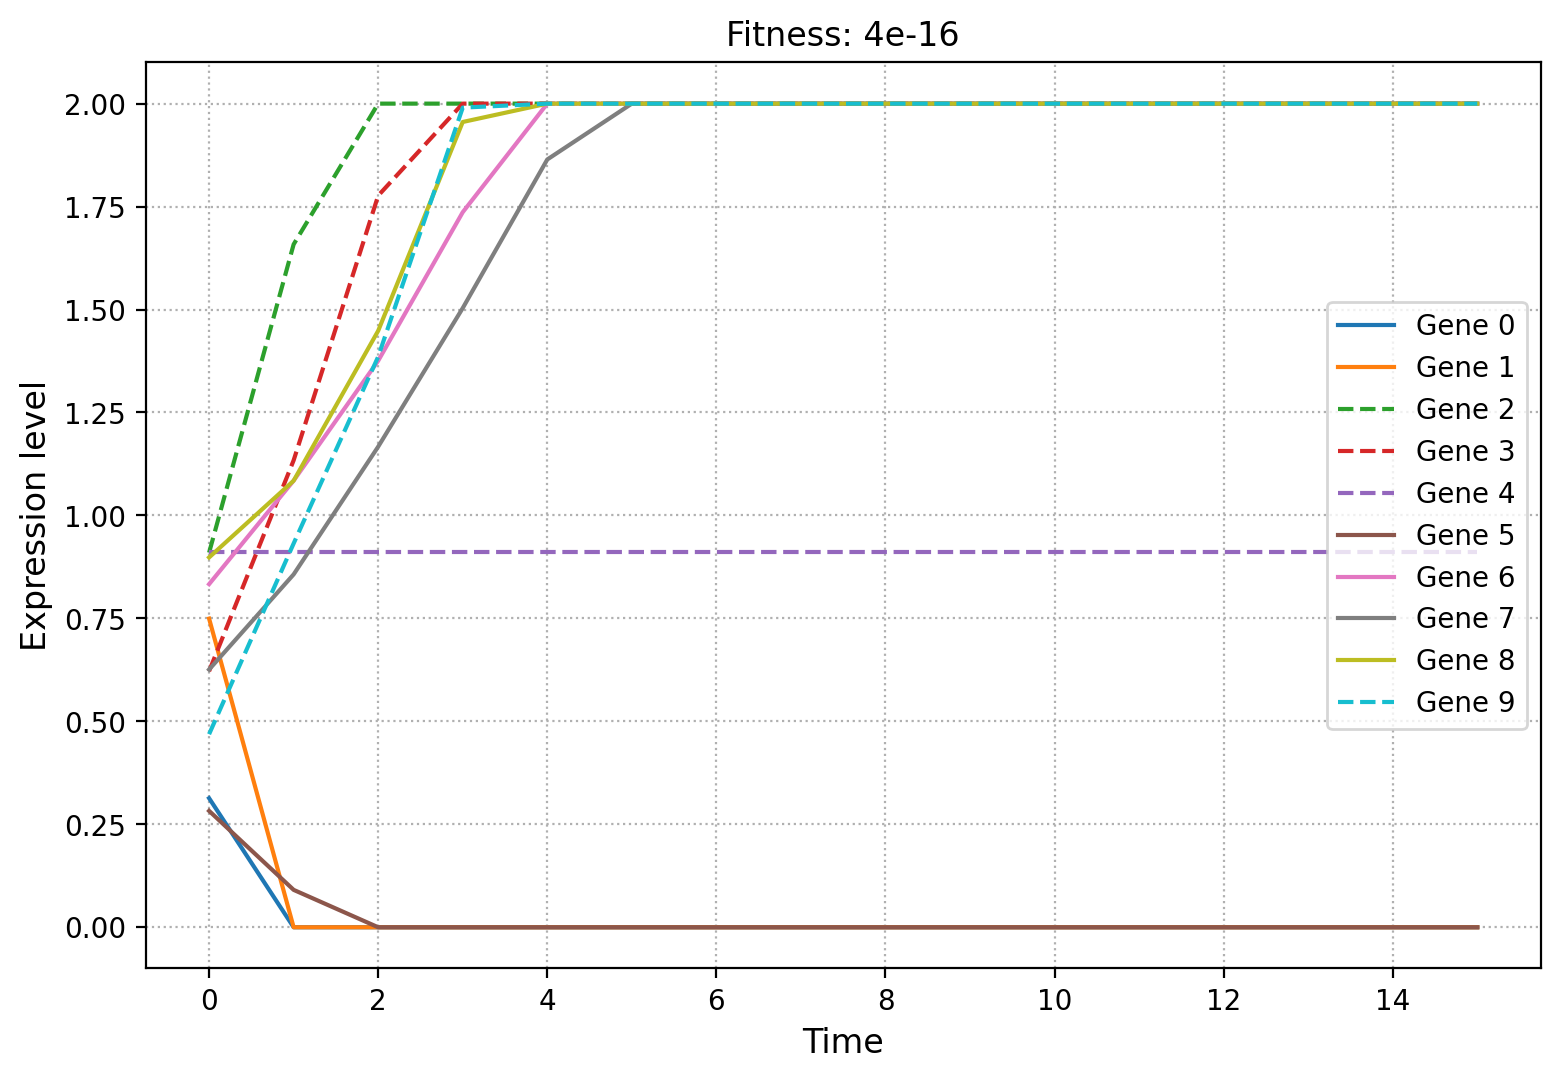

In [213]:
plot_expr(expr, fitness, 'final individual')

In [214]:
print(population[0].genes)

[100, 1079, LEADING, 0.3134010338181824, 100, 337, LAGGING, 0.7495265913300939, 100, 1431, LAGGING, 0.9095713000726744, 100, 2621, LEADING, 0.6217930647391385, 100, 2477, LEADING, 0.9113347859197863, 100, 1446, LAGGING, 0.28257874589954335, 100, 350, LAGGING, 0.833172810235814, 100, 921, LEADING, 0.6258463209557142, 100, 1261, LAGGING, 0.8980476944995918, 100, 1734, LEADING, 0.468825380219811]
